In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import sklearn 
import sklearn.preprocessing

In [2]:
# params
seed = 42

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                 header = None, sep = ' ')

# based on the .doc data description
df.columns = ['cheq_acc', 'dur_t', 'cred_hist', 'purp', 'cred_amt', 'save_acc', 
              'empl_t', 'inst_to_income', 'pers_status', 'guarant_flg',
              'residence_t', 'prop', 'age', 'inst_plan', 'house', 'n_loans',
              'job', 'n_depend', 'tel_flg', 'foreign_flg', 'target']

df.head()

,cheq_acc,dur_t,cred_hist,purp,cred_amt,save_acc,empl_t,inst_to_income,pers_status,guarant_flg,...,prop,age,inst_plan,house,n_loans,job,n_depend,tel_flg,foreign_flg,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
X = df.loc[:, df.columns != 'target']
y = df.target - 1

In [5]:
#Подготовка
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


def Gini(y, y_pred):
    res = roc_auc_score(y, y_pred) * 2 - 1
    return(res)

In [6]:
from typing import List, Union

import numpy as np
import pandas as pd

from feature_engine.encoding.base_encoder import BaseCategoricalTransformer
from feature_engine.validation import _return_tags
from feature_engine.variable_manipulation import _check_input_parameter_variables

class WoEEncoder_adj(BaseCategoricalTransformer):
    def __init__(
        self,
        variables: Union[None, int, str, List[Union[str, int]]] = None,
        ignore_format: bool = False,
    ) -> None:

        if not isinstance(ignore_format, bool):
            raise ValueError("ignore_format takes only booleans True and False")

        self.variables = _check_input_parameter_variables(variables)
        self.ignore_format = ignore_format

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Learn the WoE.
        Parameters
        ----------
        X: pandas dataframe of shape = [n_samples, n_features]
            The training input samples.
            Can be the entire dataframe, not just the categorical variables.
        y: pandas series.
            Target, must be binary.
        """
        
        X = self._check_fit_input_and_variables(X)

        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        # check that y is binary
        if y.nunique() != 2:
            raise ValueError(
                "This encoder is designed for binary classification. The target "
                "used has more than 2 unique values."
            )

        temp = pd.concat([X, y], axis=1)
        temp.columns = list(X.columns) + ["target"]

        # if target does not have values 0 and 1, we need to remap, to be able to
        # compute the averages.
        if any(x for x in y.unique() if x not in [0, 1]):
            temp["target"] = np.where(temp["target"] == y.unique()[0], 0, 1)

        self.encoder_dict_ = {}

        total_pos = temp["target"].sum()
        total_neg = len(temp) - total_pos
        temp["non_target"] = np.where(temp["target"] == 1, 0, 1)

        for var in self.variables_:
            pos = (temp.groupby([var])["target"].sum() + .5) / total_pos
            neg = (temp.groupby([var])["non_target"].sum() + .5) / total_neg

            t = pd.concat([pos, neg], axis=1)
            t["woe"] = np.log(t["target"] / t["non_target"])

            # we make an adjustment to override this error
            # if (
            #     not t.loc[t["target"] == 0, :].empty
            #     or not t.loc[t["non_target"] == 0, :].empty
            # ):
            #     raise ValueError(
            #         "The proportion of one of the classes for a category in "
            #         "variable {} is zero, and log of zero is not defined".format(var)
            #     )

            self.encoder_dict_[var] = t["woe"].to_dict()

        self._check_encoding_dictionary()

        self.n_features_in_ = X.shape[1]

        return self

    # Ugly work around to import the docstring for Sphinx, otherwise not necessary
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = super().transform(X)

        return X

    transform.__doc__ = BaseCategoricalTransformer.transform.__doc__

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = super().inverse_transform(X)

        return X

    inverse_transform.__doc__ = BaseCategoricalTransformer.inverse_transform.__doc__

    def _more_tags(self):
        """
        In the current format, the tests are performed using continuous np.arrays.
        This means that when we encode some of the values, the denominator is 0
        and this the transformer raises an error, and the test fails.
        For this reason, most sklearn transformers will fail. And it has nothing to
        do with the class not being compatible, it is just that the inputs passed
        are not suitable
        """
        tags_dict = _return_tags()
        tags_dict["_skip_test"] = True
        return tags_dict

In [7]:
from feature_engine.encoding import OneHotEncoder
OneHot_module = OneHotEncoder()
WoE_module = WoEEncoder_adj()

In [8]:
StScal_mdl = sklearn.preprocessing.StandardScaler()
MMScal_mdl = sklearn.preprocessing.MinMaxScaler(feature_range=(1, 2))
RobScal_mdl = sklearn.preprocessing.RobustScaler()

In [9]:
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import YeoJohnsonTransformer

WinsTrans_module = Winsorizer()
LogTrans_module  = LogTransformer(base = '10')
PwrTrans_module  = PowerTransformer(exp = 0.5)
BxCxTrans_module = BoxCoxTransformer()
YeoJTrans_module = YeoJohnsonTransformer()


In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

RUS_module    = RandomUnderSampler(random_state = seed)
ROS_module    = RandomOverSampler(random_state = seed)
SMOTE_module  = SMOTE(random_state = seed)
ADASYN_module = ADASYN(random_state = seed)

In [11]:
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)


from feature_engine.selection  import SmartCorrelatedSelection
SmartSel_module = SmartCorrelatedSelection(
    # variables=X.columns.to_list(),
    method="pearson",                # можно взять свою функцию
    threshold=0.3,                   # порог корреляции
    selection_method="variance",     # из коррелирующих групп выбираем признак с наиб дисперсией
    estimator=None,                  # понадобится для selection_method="model_performance"        
    cv=5
)
from feature_engine.selection  import RecursiveFeatureAddition
RecFeatAdd_module = RecursiveFeatureAddition( # rather slow
    lgbm_mdl,
    threshold = 0.005
)

In [12]:
# import umap
import umap.umap_ as umap

class DimensionReducer():
    """
    Ugly wrapper fir various dimension reduction classes. Needed for 2 reasons:
    1. Features are not replaced, new ones are just added to df
    2. PCA output: np.array, should be replaced with pd.DataFrame 
    
    Comment AM: 
    1. Could be united with TransformerAdj class below, 
    2. .super() could be used
    """
    def __init__(self, gen_class, affx='feat', **kwargs):
        self.reducer = gen_class(**kwargs)
        self.affx = affx
        # self.reducer.set_params()
        
    def fit(self, X, y):
        self.reducer.fit(X, y)
        return self
    
    def transform(self, X):
        # potentially 
        Z = self.reducer.transform(X)
        return Z
    
    def set_params(self, **kwargs):
        self.reducer.set_params(**kwargs)
        return self  


Isomap_module = DimensionReducer(
    gen_class = sklearn.manifold.Isomap,
    n_neighbors = 5, #количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 15,  #сколько оставить компонент; по дефолту - 2
    path_method = "auto", #алгоритм, который вычисляет кратчайший путь. Варианты см. на странице функции. Этот подбирает сам.
    neighbors_algorithm = "auto", #алгоритм, который ищет соседей. Инстанс класса NearestNeighbours
    n_jobs = -1 #объект умеет быть многопоточным! -1 займет все ядра
)

PCA_module = DimensionReducer(
    gen_class = sklearn.decomposition.PCA,
    n_components = 2,    # сколько оставить компонентов; по дефолту - все
    whiten = False,      # отключаем whitening - декорреляцию фичей
    svd_solver = "full", # детали SVD преобразования, за подробностями см. доки
)

UMAP_module = DimensionReducer(
    gen_class = umap.UMAP,
    n_neighbors = 5,  # количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 2, # сколько оставить компонентов; по дефолту - 2
    min_dist = 0.1    # минимальная дистанция, которую можно сохранять между точками в получающемся пространстве. 
    # Гиперпараметр. При увеличении начинает лучше улавливать общую структуру, но хуже - локальную
)

In [13]:
train = pd.concat([y, X], axis=1)
X_train_b = []
y_train_b = []
X_bag = []
y_bag = []
for i in range (100):
    a = (train.sample(n = 1000,  replace=True, random_state = i))
    b = pd.concat([train, a, a]).drop_duplicates(keep=False)
    X_train_b.append(a.loc[:, a.columns != 'target'])
    y_train_b.append(a.target)
    X_bag.append(b.loc[:, b.columns != 'target'])
    y_bag.append(b.target)

In [36]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
    # ('mis', MeanImp_module),
    ('encode', OneHot_module),
     ('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module), 
        #('imb', ADASYN_module),
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.87trial/s, best loss: -0.758]


In [37]:
results_lgbm = pd.DataFrame({"full" : gini})
results1_lgbm = pd.DataFrame({"full" : b_acc})
results2_lgbm = pd.DataFrame({"full" : f1})

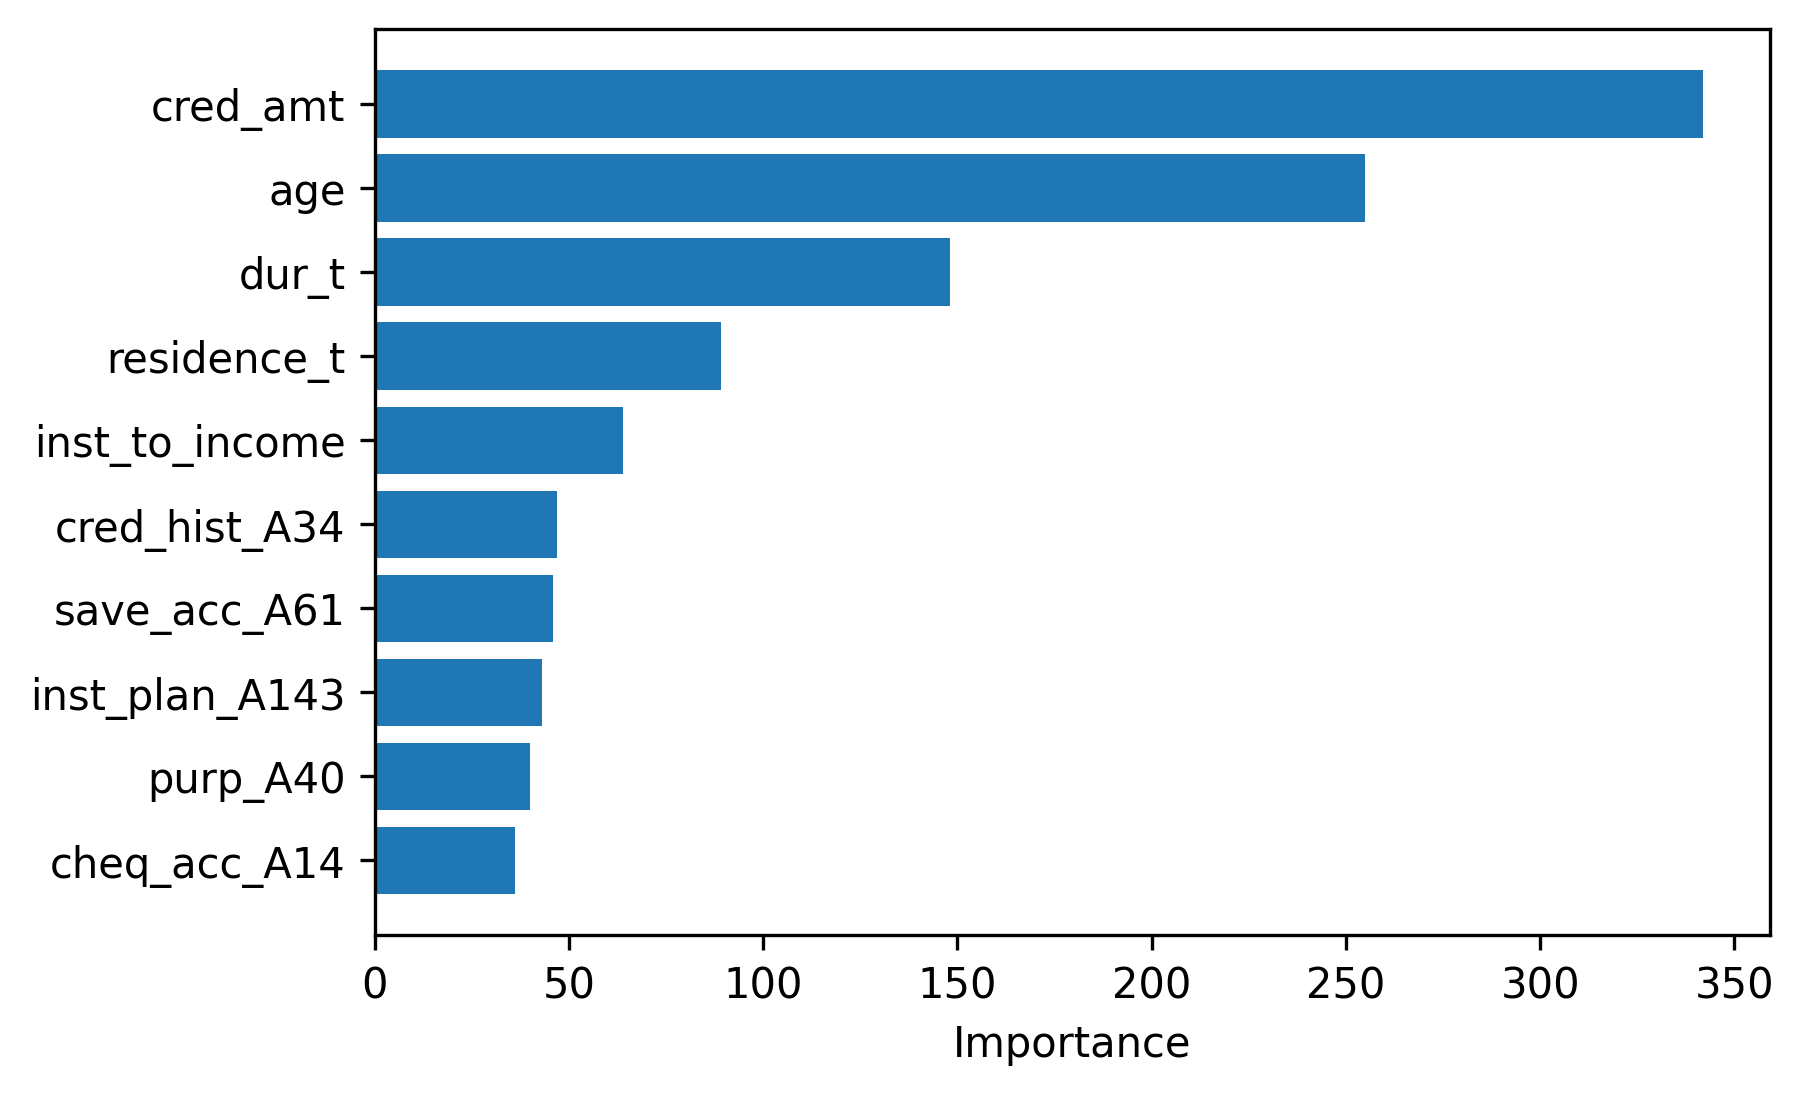

In [38]:
plt.rcParams['figure.dpi'] = 300
#mdl_pipe_impute.fit(X, y)
names = list(OneHot_module.transform(X).columns)
feature_importances = mdl_pipe_impute.named_steps['model'].feature_importances_
imp = pd.DataFrame({'Features': names,
                        'Importances': feature_importances})
imp.sort_values(by='Importances', inplace=True)
imp = imp.tail(10)
plt.barh(imp['Features'], imp['Importances'])
plt.xlabel('Importance')
plt.show()

In [42]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
        #('mis', MedImp_module),
    ('encode', OneHot_module),
     ('Scaling', RobScal_mdl),
      #('Trans', YeoJTrans_module),  
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67trial/s, best loss: -0.758]


In [43]:
results_lgbm['No transformation'] = gini
results1_lgbm['No transformation'] = b_acc
results2_lgbm['No transformation'] = f1

In [44]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
        #('mis', MedImp_module),
    ('encode', OneHot_module),
     #('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module),  
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|███████████████████████████████████████████████| 40/40 [00:19<00:00,  2.03trial/s, best loss: -0.7589999999999999]


In [45]:
results_lgbm['No Scaling'] = gini
results1_lgbm['No Scaling'] = b_acc
results2_lgbm['No Scaling'] = f1

In [46]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
        #('mis', MedImp_module),
    ('encode', WoE_module),
     ('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module),  
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63trial/s, best loss: -0.764]


In [47]:
results_lgbm['No OneHot encoding'] = gini
results1_lgbm['No OneHot encoding'] = b_acc
results2_lgbm['No OneHot encoding'] = f1

In [48]:
results_lgbm.mean()

full                  0.700150
No transformation     0.700092
No Scaling            0.675482
No OneHot encoding    0.659216
dtype: float64

In [49]:
results1_lgbm.mean()

full                  0.756839
No transformation     0.756811
No Scaling            0.727002
No OneHot encoding    0.716353
dtype: float64

In [50]:
results2_lgbm.mean()

full                  0.658937
No transformation     0.658891
No Scaling            0.616293
No OneHot encoding    0.600622
dtype: float64

In [51]:
results_lgbm.std()

full                  0.028833
No transformation     0.028776
No Scaling            0.026681
No OneHot encoding    0.026262
dtype: float64

In [52]:
results1_lgbm.std()

full                  0.014757
No transformation     0.014719
No Scaling            0.014996
No OneHot encoding    0.015739
dtype: float64

In [53]:
results2_lgbm.std()

full                  0.023887
No transformation     0.023825
No Scaling            0.024955
No OneHot encoding    0.026222
dtype: float64

In [54]:
from scipy import stats
stats.ttest_ind(results_lgbm['full'], results_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.014126036077931487, pvalue=0.9887436521643924)

In [55]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.013515342867517037, pvalue=0.9892302533252744)

In [56]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.013530650170164178, pvalue=0.989218056398572)

In [57]:
stats.ttest_ind(results_lgbm['full'], results_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=6.279544931425403, pvalue=2.128920111489714e-09)

In [58]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=14.18154999628779, pvalue=5.794056661117409e-32)

In [59]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=12.344595912541592, pvalue=2.5222096647296957e-26)

In [60]:
stats.ttest_ind(results_lgbm['full'], results_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=10.495822965368792, pvalue=9.672224036778324e-21)

In [61]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=18.764975623939545, pvalue=9.58015575876009e-46)

In [62]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=16.440618556654087, pvalue=9.237058427273409e-39)

[Text(0.5, 1.0, 'LGBM and preprocessing')]

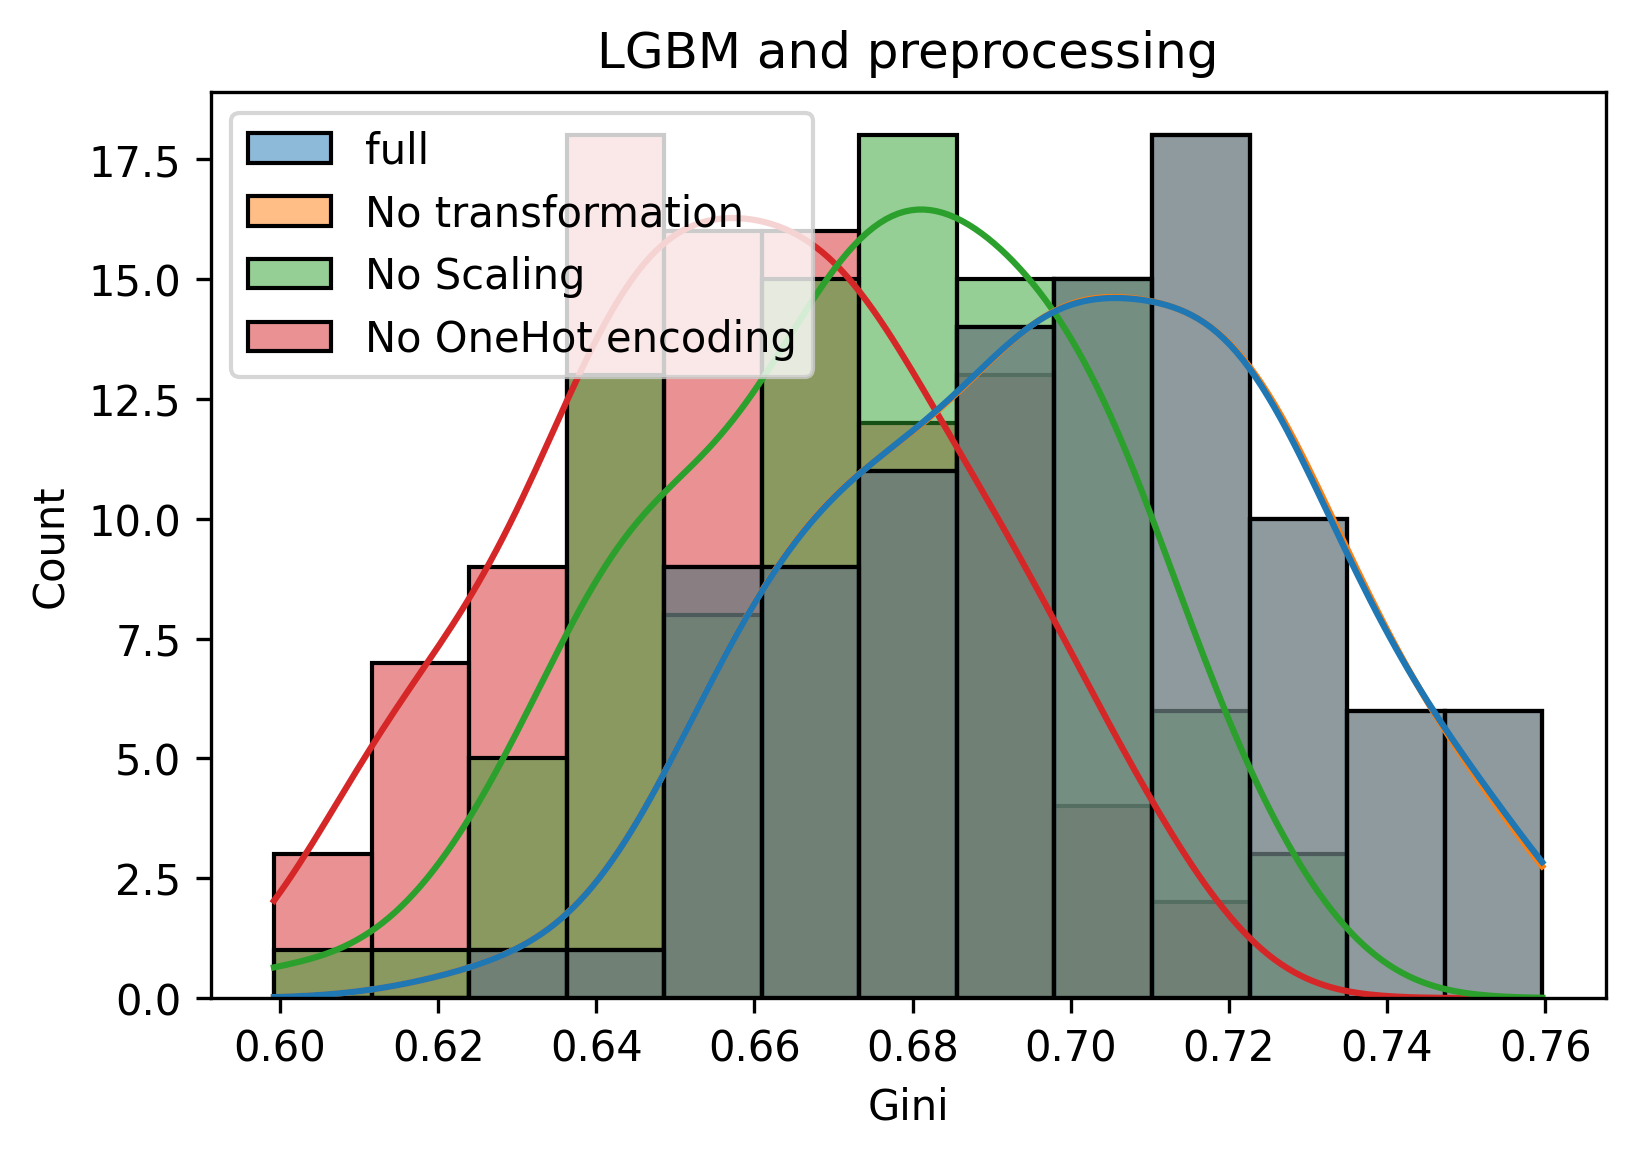

In [63]:
plt.rcParams['figure.dpi'] = 300
ax = sns.histplot(results_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Gini", fontsize = 10)
ax.set(title='LGBM and preprocessing')

[Text(0.5, 1.0, 'LGBM and preprocessing')]

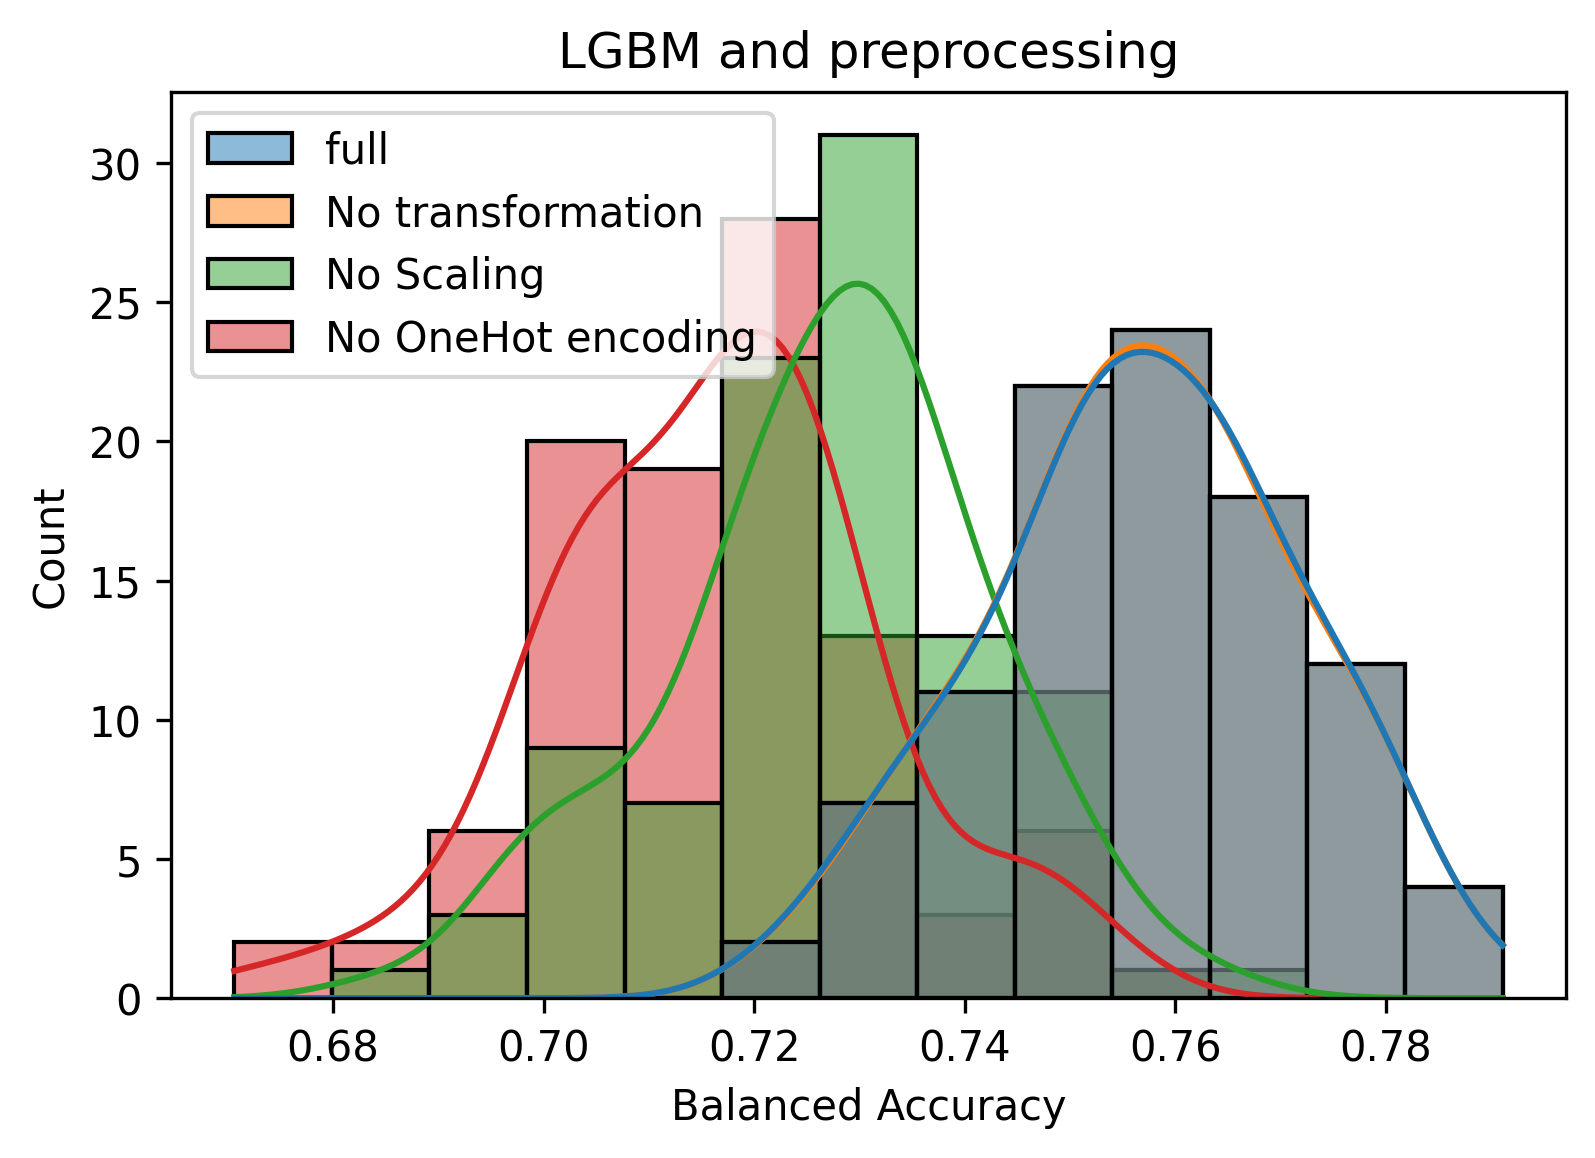

In [64]:
ax = sns.histplot(results1_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Balanced Accuracy", fontsize = 10)
ax.set(title='LGBM and preprocessing')

[Text(0.5, 1.0, 'LGBM and preprocessing')]

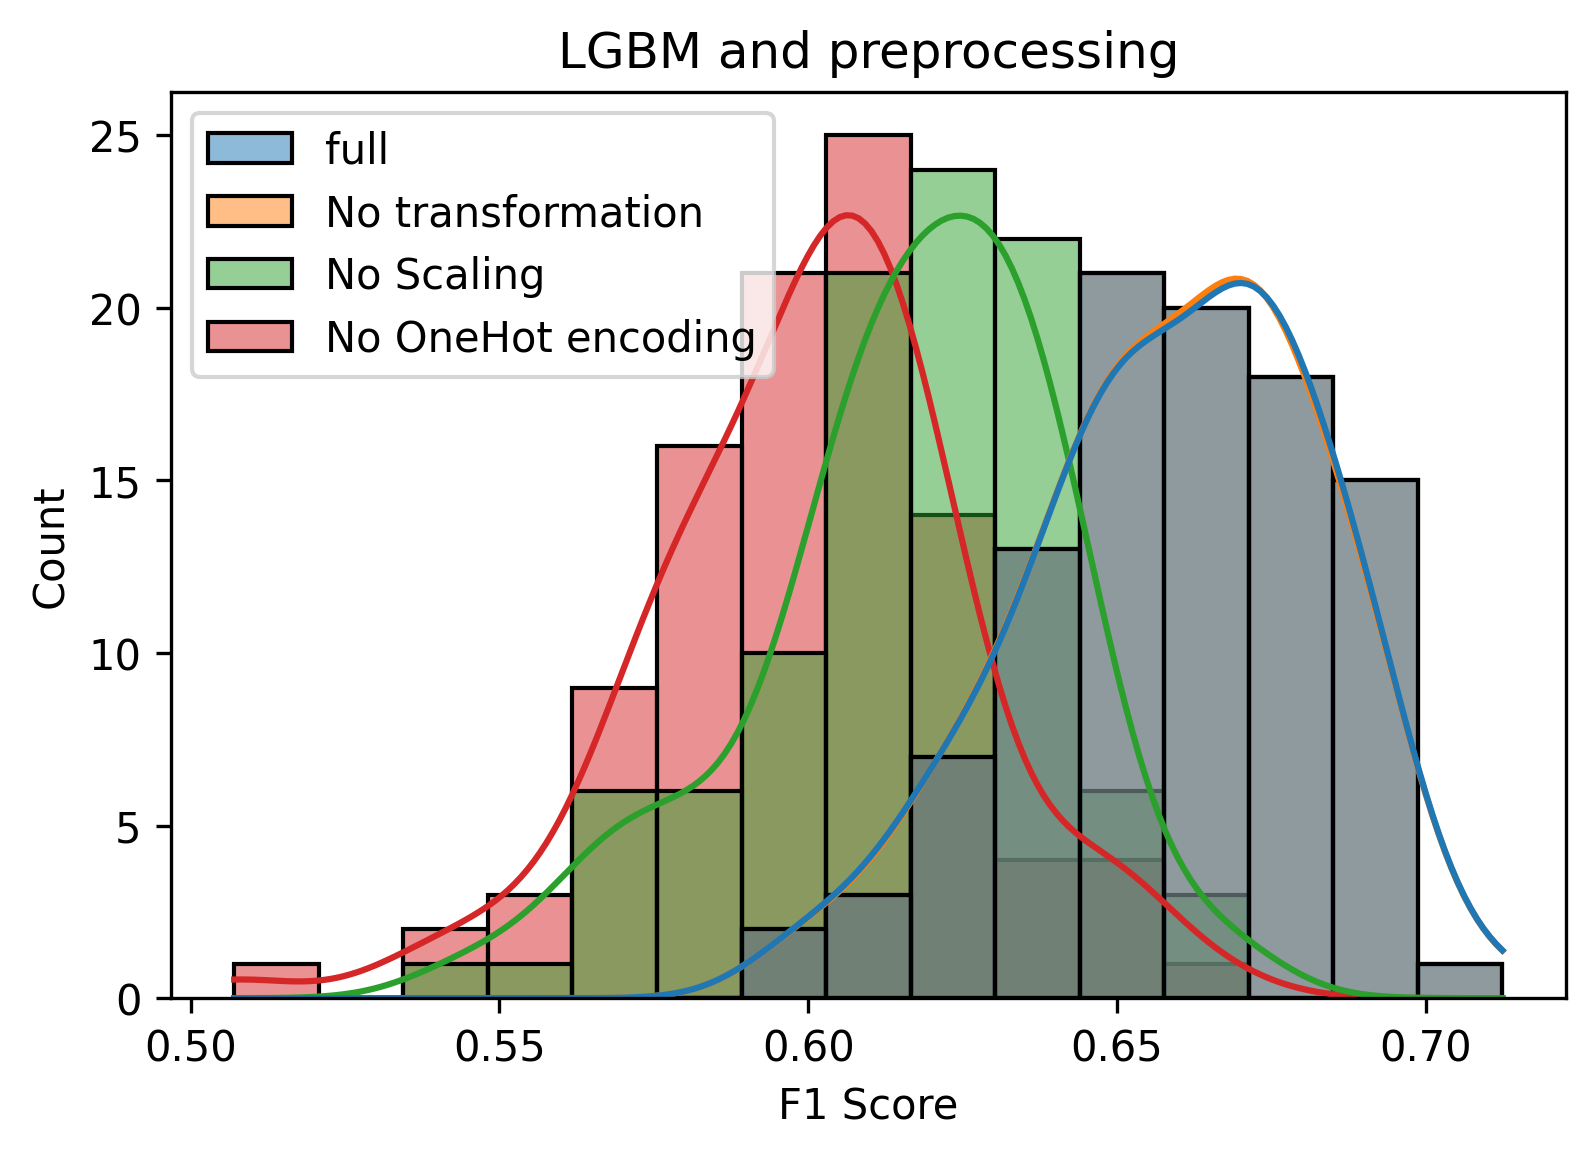

In [65]:
ax = sns.histplot(results2_lgbm, kde=True, element = 'bars')
ax.set_xlabel("F1 Score", fontsize = 10)
ax.set(title='LGBM and preprocessing')